In [1]:
%matplotlib inline

In [2]:
import MDAnalysis
import MDAnalysis.analysis
import MDAnalysis.lib.distances

import numpy as np
import matplotlib
import pylab

In [11]:
file='cu_melt/b10000.xyz'
#file='cu_melt/c.dcd'
simulation=MDAnalysis.Universe(file)
all_atoms=simulation.atoms
natom=all_atoms.n_atoms
print(natom)

posits=all_atoms.positions
print(posits.ndim, posits.shape, posits.dtype)

256
2 (256, 3) float32


D:\anaconda3\envs\tensorflow1\lib\site-packages\MDAnalysis\topology\guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: 1
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [12]:
# set up rdf
dmin, dmax = 0.0, 16.0
nbins = 100
rdf, edges = np.histogram([0], bins=nbins, range=(dmin, dmax))
rdf *= 0
rdf = rdf.astype(np.float64)  # avoid possible problems with '/' later on

for i in range(1,natom):    #loop from 0 ~ n-1 because of select_atoms(bynum idx) starts from 1
    selector= "bynum " + str(i)
    atom_i=all_atoms.select_atoms(selector)
    #print( "center atom is ", atom_i )
    selector= "bynum " + str(i+1) + ":" + str(natom)
    rest_atoms=all_atoms.select_atoms(selector)
    #print( "rest atom are ", rest_atoms )
    dist = np.zeros( (1, rest_atoms.n_atoms) , dtype=np.float64)
    MDAnalysis.lib.distances.distance_array( atom_i.positions, rest_atoms.positions, result=dist, backend='serial')
    new_rdf, edges = np.histogram(dist, bins=nbins, range=(dmin, dmax))
    rdf += new_rdf

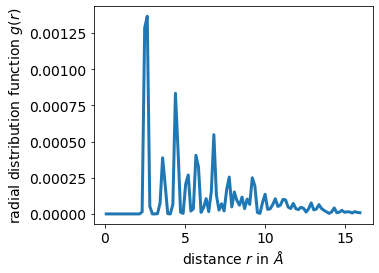

In [13]:
boxvolume = 1
numframes = 1
boxvolume /= numframes  # average volume

# Normalize RDF
radii = 0.5 * (edges[1:] + edges[:-1])
vol = (4. / 3.) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))

# normalization to the average density n/boxvolume in the simulation
density = natom / boxvolume
# This is inaccurate when solutes take up substantial amount
# of space. In this case you might want to use
## import MDAnalysis.units
## density = MDAnalysis.units.convert(1.0, 'water', 'Angstrom^{-3}')
norm = density * (natom - 1) / 2 * numframes
rdf /= norm * vol

outfile = './rdf.dat'
with open(outfile, 'w') as output:
    for radius, gofr in zip(radii, rdf):
        output.write("{radius:8.3f} \t {gofr:8.3f}\n".format(**vars()))
#print( "g(r) data written to {outfile!r}" % (**vars()) )

matplotlib.rc('font', size=14)
matplotlib.rc('figure', figsize=(5, 4))
pylab.clf()
pylab.plot(radii, rdf, linewidth=3)
pylab.xlabel(r"distance $r$ in $\AA$")
pylab.ylabel(r"radial distribution function $g(r)$")
pylab.savefig("./rdf.png")    